In [2]:
import time, matplotlib, sklearn

# visualization 
import matplotlib.pyplot as plt 

# data wrangling
import pandas as pd
import numpy as np 

# data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer

# learning
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

# the data intro has been tested with the following versions
print("pandas        Tested version: 2.0.3   Your version: %s" % pd.__version__)
print("numpy         Tested version: 1.21.5  Your version: %s" % np.__version__)
print("matplotlib    Tested version: 3.5.3   Your version: %s" % matplotlib.__version__)
print("scikit-learn  Tested version: 1.2.2   Your version: %s" % sklearn.__version__)

pandas        Tested version: 2.0.3   Your version: 2.1.4
numpy         Tested version: 1.21.5  Your version: 1.26.4
matplotlib    Tested version: 3.5.3   Your version: 3.8.3
scikit-learn  Tested version: 1.2.2   Your version: 1.4.1.post1


# Load data
If you put the data set in the same folder as this notebook, you can use the following code to load the data set. 

In [3]:
# description
description = pd.read_csv('WiDS_Datathon_2020_Dictionary.csv')
description_dict = description.set_index('Variable Name').to_dict(orient='index')
# data
df = pd.read_csv('training_v2.csv')

df.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


The dataset contains many different variables, including:

#### Target variable
* *hospital_death*: 'Whether the patient died during this hospitalization.

#### Identifiers
* *patient_id*: Unique identifier associated with a patient
* *encounter_id*: Unique identifier associated with a patient unit stay
* *hospital_id*: Unique identifier associated with a hospital
* *icu_id*: A unique identifier for the unit to which the patient was admitted

#### Demographics
* *age*: The age of the patient on unit admission.
* *bmi*: The body mass index of the person on unit admission.
* *ethnicity*: The common national or cultural tradition which the person belongs to.
* *gender*: The genotypical sex of the patient.
* *height*: The height of the person on unit admission

#### Health indicators
A few examples:
* *elective_surgery*: Whether the patient was admitted to the hospital for an elective surgical operation
* *h1_diasbp_invasive_max*: The patient's highest diastolic blood pressure during the first hour of their unit stay, invasively measured
* *h1_diasbp_invasive_min*: The patient's lowest diastolic blood pressure during the first hour of their unit stay, invasively measured
* *gcs_verbal_apache*: The verbal component of the Glasgow Coma Scale measured during the first 24 hours which results in the highest APACHE III score
* *immunosuppression*: Whether the patient has their immune system suppressed within six months prior to ICU admission for any of the following reasons; radiation therapy, chemotherapy, use of non-cytotoxic immunosuppressive drugs, high dose steroids (at least 0.3 mg/kg/day of methylprednisolone or equivalent for at least 6 months).

In [4]:
# you can retrieve the description of a variable in the data set from the description dictionary as follows
description_dict['immunosuppression']

{'Category': 'APACHE comorbidity',
 'Unit of Measure': nan,
 'Data Type': 'binary',
 'Description': 'Whether the patient has their immune system suppressed within six months prior to ICU admission for any of the following reasons; radiation therapy, chemotherapy, use of non-cytotoxic immunosuppressive drugs, high dose steroids (at least 0.3 mg/kg/day of methylprednisolone or equivalent for at least 6 months).',
 'Example': '1'}

# Pre-processing
This is a real-world data set, meaning that it is **messy**. Two key difficulties are categorial features and missing values.

> **To avoid information leakage, any pre-processing steps must be based on the training data only.** For example, when we compute the mean, this must be computed based on the training data set.

### Categorical Features
Many (implementations of) machine learning algorithms cannot handle categorical features automatically. This is often dealt with through *one-hot-encoding*, where each category of a feature is transformed into a binary feature.

When a feature contains many categories, this results in a very sparse data set with many features. As such, it can be worthwile to use domain expertise to merge particular categories in order to reduce the number of one-hot-encoded features.

### Missing Values
The data set contains a lot of missing values (around 35% of the values is missing). There are several ways to deal with this, some ideas to try:

* Replace missing values with the mean (numerical features) or median (categorical features), e.g., using [`SimpleImputer`](https://scikit-learn.org/stable/modules/impute.html#univariate-feature-imputation).
* Drop features with many missing values.
* Model-based imputation strategies, such as [KNNImputer](https://scikit-learn.org/stable/modules/impute.html#nearest-neighbors-imputation).
* Domain-knowledge inspired replacement. For example, for features related to medical measurements, it is expected that the entered data is abnormal in some way. As such, replacing by the mean or median can paint a skewed picture. One way to deal with this would be to identify a normal range for different measurements, based on domain expertise. *Note: this is a very time consuming strategy which we do not necessarily recommend in the time span of this project.*

We encourage you to try several approaches and see what works best.

## Example of  Minimal Pre-Processing
Below you can find an example of pre-processing the data set for classification. We showcase both 'manual' pre-processing steps through `pandas` as well as a (small) scikit-learn `Pipeline`. Feel free to use whatever you are most comfortable with in your project.

In [5]:
test_size = 0.2 # proportion for train versus test+val split
val_size = 0.5 # proportion for test versus val split
random_state = 42  # random state is used to set a seed for randomness, which is only relevant for reproducibility purposes
max_missing = 0.8  # maximum percentage of missing values for a column to be dropped

In [6]:
start_time = time.time()

# save features
X = df.copy().drop(['hospital_death', 'patient_id', 'encounter_id', 'hospital_id', 'icu_id', # drop identifiers
                    'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', # drop APACHE scores
                    'apache_2_bodysystem'], # drop because of similarity with apache_3j_bodysystem
                   axis=1)
# save target variable
y = df['hospital_death'].copy()
# save APACHE scores for later evaluation on train / test / validation data
y_apache = df['apache_4a_hospital_death_prob'].copy()

""" SPLIT DATA SET """
# split the dataset into train and test+validation set
(
    X_train,
    X_test,
    y_train,
    y_test,
    y_apache_train,
    y_apache_test,
    ) = train_test_split(X, y, y_apache, 
                         test_size=test_size, # used for testing and validation
                         random_state=random_state # for reproducibility
                        ) 
# split the test set into test + validation set
(
    X_val,
    X_test,
    y_val,
    y_test,
    y_apache_val,
    y_apache_test,
    ) = train_test_split(X_test, y_test, y_apache_test, 
                         test_size=val_size, # used for testing and validation
                         random_state=random_state # for reproducibility
                        ) 

"""MISSING VALUES"""
# drop columns with many missing values
missing = X_train.isna().sum() > max_missing * len(X_train)
missing = missing[missing].index
X_train = X_train.drop(missing, axis=1)
X_val = X_val.drop(missing, axis=1)
X_test = X_test.drop(missing, axis=1)

"""FURTHER PROCESSING PIPELINE"""
# define pre-processing steps for numerical features
num_transformer = Pipeline(steps=[("constant", VarianceThreshold()), # remove constant features
                                  ("imputer", SimpleImputer(strategy="mean")),
                                 ])
# define preprocessing steps for categorical features
cat_transformer = Pipeline(steps=[("encoder", OneHotEncoder(drop='first', sparse_output=False, handle_unknown="ignore"))])
# create preprocessing pipeline
prep_pipeline = ColumnTransformer(
    transformers=[
        ('num', num_transformer, make_column_selector(dtype_exclude=object)), # apply to columns NOT of type object (int or float)
        ('cat', cat_transformer, make_column_selector(dtype_include=object)) # apply to columns of type object
    ])
# pipeline
prep_pipeline.fit(X_train, y_train)
display(prep_pipeline) # disply preprocessing pipeline

# transform data sets
X_train = pd.DataFrame(prep_pipeline.transform(X_train), columns=prep_pipeline.get_feature_names_out())
X_val = pd.DataFrame(prep_pipeline.transform(X_val), columns=prep_pipeline.get_feature_names_out())
X_test = pd.DataFrame(prep_pipeline.transform(X_test), columns=prep_pipeline.get_feature_names_out())
        
"""PRINT STATS"""
print("Time: %.2fs" % (time.time() - start_time))
print("Train set: %s rows, %s columns" % X_train.shape)
print("Validation set: %s rows, %s columns" % X_val.shape)
print("Test set: %s rows, %s columns" % X_test.shape)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('constant',
                                                  VarianceThreshold()),
                                                 ('imputer', SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000143761BF610>),
                                ('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000143761A27F0>)])

Time: 1.60s
Train set: 73370 rows, 184 columns
Validation set: 9171 rows, 184 columns
Test set: 9172 rows, 184 columns


## Simple Logistic Regression Model
We can now train a simple logistic regression model.

> **Warning**. The following code will lead to a convergence warning. To solve this "issue", you can increase `max_iter` and/or apply a `sklearn.preprocessing.StandardScaler()`. However, the model still performance reasonably well even without convergence.

In [7]:
start_time = time.time()

from sklearn.preprocessing import StandardScaler

# train logistic regression model
lr = LogisticRegression(penalty='l2', solver='saga')
lr.fit(X_train, y_train)

print("Time: %.2fs" % (time.time() - start_time))

Time: 13.66s


c:\Users\Aahaan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# APACHE IV Scores
APACHE ("Acute Physiology and Chronic Health Evaluation") is a scoring system assessing severity of illness and prognoses of ICU patients. The scoring system has been improved over time, with APACHE II being released in 1985, APACHE III in 1991, and finally APACHE IV in 2006. APACHE IV has been evaluated and validated in patients for mortality outcome. 

In the dataset, the *apache_4a_hospital_death_prob* column corresponds to the APACHE IV probabilistic prediction of in-hospital mortality for the patient which utilizes the APACHE III score and other covariates, including diagnosis.
* `-1` means the score couldn't be calculated for some reason. In particular, the patient encounter could have been a re-admission. 
* `NaN` indicates a missing score, due to e.g., a missing covariate that made it impossible to compute the score. 


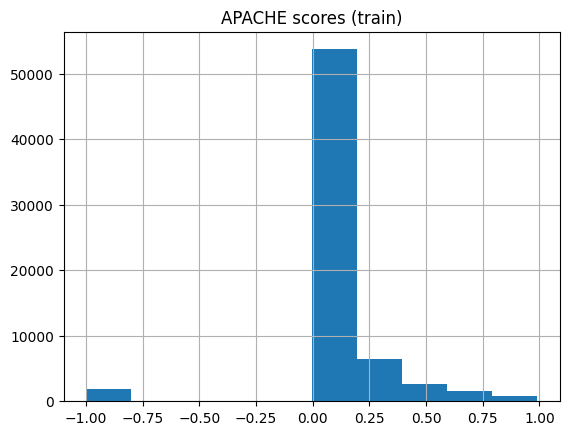

In [8]:
# histogram
y_apache_train.hist()
plt.title("APACHE scores (train)")
plt.show()

In [9]:
c = []

for columns in df.columns:
    c.append((columns, (df[columns].isna().sum()) / len(df)))

data = pd.DataFrame(c)


<Axes: >

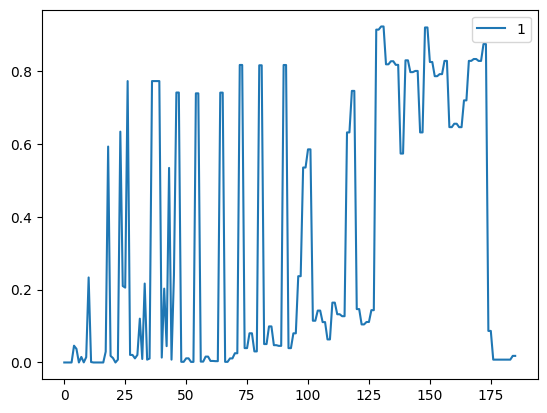

In [10]:
data.plot(kind="line")

In [11]:
data.rename(columns={0: "Column", 1: "Metric"}, inplace = True)

In [12]:
#data.drop(["level_0", "index"], inplace = True, axis = 1)
data.set_index("Column", inplace = True)

In [13]:
dropped_columns = list(data[data["Metric"] >= 0.5].index)

In [14]:
df.drop(columns = dropped_columns, inplace = True)

In [15]:
dropped_columns
df

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.730000,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.420000,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.950000,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.640000,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,91592,78108,30,0,75.0,23.060250,0,Caucasian,M,177.8,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,Sepsis,Cardiovascular
91709,66119,13486,121,0,56.0,47.179671,0,Caucasian,F,183.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
91710,8981,58179,195,0,48.0,27.236914,0,Caucasian,M,170.2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
91711,33776,120598,66,0,NaN,23.297481,0,Caucasian,F,154.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory


In [16]:
#labels =  df["hospital_death"]
#features = df[["gender", "age"]]

Predicting the baseline on the test set:

In [17]:
predictions_baseline = lr.predict(X_test)

Training the random forest model:

In [18]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 10)
# Train the model on training data
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10)

Predicting the random forest on the test set:

In [19]:
# Use the forest's predict method on the test data
predictions_rf = rf.predict(X_test)


Calculating the mse for the baseline:

In [20]:
# Calculate the absolute errors
errors = abs(predictions_baseline - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, predictions_baseline)

Mean Absolute Error: 0.08 degrees.


Calculating the MSE for the random forest model:

In [22]:
# Calculate the absolute errors
errors = abs(predictions_rf - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, predictions_rf)

Mean Absolute Error: 0.07 degrees.


Calculating the accuracy, recall, precision and f-1 scores for the baseline:

In [23]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
 
print(accuracy_score(y_test, predictions_baseline))
print(recall_score(y_test, predictions_baseline))
print(precision_score(y_test, predictions_baseline))
print(f1_score(y_test, predictions_baseline))


0.9192106410815526
0.14791403286978508
0.6358695652173914
0.24


Calculating the accuracy, recall, precision and f-1 scores for the random forest model:

In [24]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
 
print("Accuracy: {}".format(accuracy_score(y_test, predictions_rf)))
print("Recall: {}".format(recall_score(y_test, predictions_rf)))
print("Precision: {}".format(precision_score(y_test, predictions_rf)))
print("F-1 Score: {}".format(f1_score(y_test, predictions_rf)))

Accuracy: 0.9258613170518971
Recall: 0.23893805309734514
Precision: 0.7078651685393258
F-1 Score: 0.3572778827977316


### Gradient Boosting Model:

In [25]:
from sklearn.ensemble import HistGradientBoostingClassifier

clf_gb = HistGradientBoostingClassifier(max_iter=100).fit(X_train, y_train)


In [26]:
predictions_gb = clf_gb.predict(X_test)

In [27]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score


print("Accuracy: {}".format(accuracy_score(y_test, predictions_gb)))
print("Recall: {}".format(recall_score(y_test, predictions_gb)))
print("Precision: {}".format(precision_score(y_test, predictions_gb)))
print("F-1 Score: {}".format(f1_score(y_test, predictions_gb)))

Accuracy: 0.9324029655473179
Recall: 0.3527180783817952
Precision: 0.7209302325581395
F-1 Score: 0.47368421052631576


### XG Boost Model:

In [28]:
from xgboost import XGBClassifier

bst = XGBClassifier(n_estimators=2, learning_rate=1, objective='binary:logistic')
# fit model
bst.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [29]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

predictions_xgb = bst.predict(X_test)
 
print(accuracy_score(y_test, predictions_xgb))
print(recall_score(y_test, predictions_xgb))
print(precision_score(y_test, predictions_xgb))
print(f1_score(y_test, predictions_xgb))

0.922808547754034
0.29077117572692796
0.610079575596817
0.3938356164383562


### Gradient Descent Model:

In [30]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss="hinge", penalty="l2")
clf.fit(X_train, y_train)

SGDClassifier()

In [31]:
predictions_gd = clf.predict(X_test)
print("Accuracy: {}".format(accuracy_score(y_test, predictions_gd)))
print("Recall: {}".format(recall_score(y_test, predictions_gd)))
print("Precision: {}".format(precision_score(y_test, predictions_gd)))
print("F-1 Score: {}".format(f1_score(y_test, predictions_gd)))

Accuracy: 0.9247710423026603
Recall: 0.2225031605562579
Precision: 0.701195219123506
F-1 Score: 0.3378119001919386


In [32]:
f1_scores = {
    'baseline': f1_score(y_test, predictions_baseline),
    'rf': f1_score(y_test, predictions_rf),
    'gb': f1_score(y_test, predictions_gb),
    'xgb': f1_score(y_test, predictions_xgb),
    'gd': f1_score(y_test, predictions_gd)
}
sorted_f1_scores = sorted(f1_scores.items(), key=lambda x: x[1], reverse=True)

sorted_f1_scores = pd.DataFrame(sorted_f1_scores, columns = ["Model", "F-1 Score"])

baseline_f1_score = sorted_f1_scores.iloc[len(sorted_f1_scores) - 1]['F-1 Score']
sorted_f1_scores['Percentage Increase'] = ((sorted_f1_scores['F-1 Score'] - baseline_f1_score) / baseline_f1_score) * 100


print(sorted_f1_scores)


      Model  F-1 Score  Percentage Increase
0        gb   0.473684            97.368421
1       xgb   0.393836            64.098174
2        rf   0.357278            48.865784
3        gd   0.337812            40.754958
4  baseline   0.240000             0.000000


In [157]:
#import fairlearn
#from fairlearn.metrics import MetricFrame, make_derived_metric
#from sklearn.metrics import precision_score
#from fairlearn.metrics import selection_rate, count, false_positive_rate, false_negative_rate
#from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference
#from sklearn.calibration import CalibrationDisplay
#mf = MetricFrame(metrics={'selection rate (COMPAS)' : selection_rate}, 
#                 y_true = y_test["hospital_death"], 
#                 y_pred = predictions,
#                 sensitive_features = y_test["gender"])
# print results
#display(mf.by_group)
#print("Overall SR: %.2f" % mf.overall[0])



In [156]:
# summarize demographic parity as the max difference between groups
#print("demographic parity diff: %.2f" % mf.difference(method='between_groups')[0])

# summarize demographic parity using the metric (this gives the exact same result as mf.difference())
#dpd = demographic_parity_difference(y_true=data['two_year_recid'], 
#                                    y_pred=data['decile_score_cutoff'], 
#                                    sensitive_features=data['race'], 
#                                    method='between_groups') # summarize as the max difference between any of the groups
#print("demographic parity diff: %.2f" % dpd)

In [50]:
probabilities = clf.predict_proba(X_test)
predictions_gb = clf_gb.predict(X_test)
probabilities = pd.DataFrame(probabilities, columns = ["Survival", "Death"])
predictions_gb = pd.DataFrame(predictions_gb, columns = ["Decision"])
X_test_sensitive = X_test[["cat__gender_M"]]

gb_df = probabilities.merge(predictions_gb, left_index = True, right_index = True)
gb_df = gb_df.merge(X_test_sensitive, left_index = True, right_index = True)
gb_df

,Survival,Death,Decision,cat__gender_M
0,0.975931,0.024069,0,0.0
1,0.995794,0.004206,0,1.0
2,0.930048,0.069952,0,0.0
3,0.994700,0.005300,0,1.0
4,0.992532,0.007468,0,1.0
...,...,...,...,...
9167,0.961205,0.038795,0,1.0
9168,0.968722,0.031278,0,0.0
9169,0.978630,0.021370,0,1.0
9170,0.991925,0.008075,0,1.0


Seeing demographic parity for gender:

In [68]:
gb_df[(gb_df["cat__gender_M"] == 0.0) & (gb_df["Decision"] == 0)]["Decision"].count() / gb_df[gb_df["cat__gender_M"] == 0.0]["Decision"].count()

0.9584139264990329

In [69]:
gb_df[(gb_df["cat__gender_M"] == 1.0) & (gb_df["Decision"] == 0)]["Decision"].count() / gb_df[gb_df["cat__gender_M"] == 1.0]["Decision"].count()

0.9569102462271644

In [75]:
#for rows in gb_df.index:
#    gb_df.sort_values( by = "Survival", axis=0, ascending = False, inplace = True)
#    female_survival = gb_df[(gb_df["cat__gender_M"] == 0.0) & (gb_df["Decision"] == 0)]["Decision"].count() / gb_df[gb_df["cat__gender_M"] == 0.0]["Decision"].count()
#    male_survival = gb_df[(gb_df["cat__gender_M"] == 1.0) & (gb_df["Decision"] == 0)]["Decision"].count() / gb_df[gb_df["cat__gender_M"] == 1.0]["Decision"].count()
#    while female_survival > male_survival:
#        gb_df.iloc[rows]["Decision"] = 1

Doing the oversampling + undersampling using SMOTE:

In [36]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

Tring the selected model (Gradient boosting):

In [39]:
from sklearn.ensemble import HistGradientBoostingClassifier

clf_gb = HistGradientBoostingClassifier(max_iter=100).fit(X_res, y_res)

In [40]:
predictions_gb = clf_gb.predict(X_test)

In [41]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score


print("Accuracy: {}".format(accuracy_score(y_test, predictions_gb)))
print("Recall: {}".format(recall_score(y_test, predictions_gb)))
print("Precision: {}".format(precision_score(y_test, predictions_gb)))
print("F-1 Score: {}".format(f1_score(y_test, predictions_gb)))

Accuracy: 0.9289140863497601
Recall: 0.3666245259165613
Precision: 0.6575963718820862
F-1 Score: 0.4707792207792208


In [44]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, predictions_gb)
conf_matrix

array([[8230,  151],
       [ 501,  290]], dtype=int64)

In [45]:
FP = conf_matrix[0, 1]  # False positives
TN = conf_matrix[0, 0]  # True negatives
FN = conf_matrix[1, 0]  # False negatives
TP = conf_matrix[1, 1]  # True positives

# Compute FPR and FNR
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
TPR = TP / (TP + FN)
TNR = TN / (TN + FP)

In [48]:
FNR, FPR, TNR, TPR

(0.6333754740834386, 0.01801694308555065)

Implementing a cost matrix with False Negatives penalized by having a cost of 13.002 to equalize FPR and FNR:

In [146]:
cost_matrix = {
    'FP': 1,  # Cost of false positive
    'FN': 13.1002   # Cost of false negative
}

# Compute sample weights based on misclassification costs
sample_weights = []
for y_true in y_train:
    if y_true == 0:
        sample_weights.append(cost_matrix['FP'])  # Assign higher weight to false positives
    else:
        sample_weights.append(cost_matrix['FN'])  # Assign higher weight to false negatives

# Instantiate the GradientBoostingClassifier and pass the sample weights
clf = HistGradientBoostingClassifier(random_state=42)
clf.fit(X_train, y_train, sample_weight=sample_weights)

# Make predictions
predictions_gb = clf.predict(X_test)

In [147]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score


print("Accuracy: {}".format(accuracy_score(y_test, predictions_gb)))
print("Recall: {}".format(recall_score(y_test, predictions_gb)))
print("Precision: {}".format(precision_score(y_test, predictions_gb)))
print("F-1 Score: {}".format(f1_score(y_test, predictions_gb)))

Accuracy: 0.8229393807239425
Recall: 0.8230088495575221
Precision: 0.30491803278688523
F-1 Score: 0.4449760765550239


In [148]:
conf_matrix = confusion_matrix(y_test, predictions_gb)
conf_matrix
FP = conf_matrix[0, 1]  # False positives
TN = conf_matrix[0, 0]  # True negatives
FN = conf_matrix[1, 0]  # False negatives
TP = conf_matrix[1, 1]  # True positives

# Compute FPR and FNR
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
TPR = TP / (TP + FN)
TNR = TN / (TN + FP)

FNR, FPR, TNR, TPR

(0.17699115044247787, 0.17706717575468323)

Making the ROC curve:

In [149]:
lr_probs = clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
lr_probs

array([0.06438752, 0.01518053, 0.39918699, ..., 0.19440774, 0.0223421 ,
       0.6499436 ])

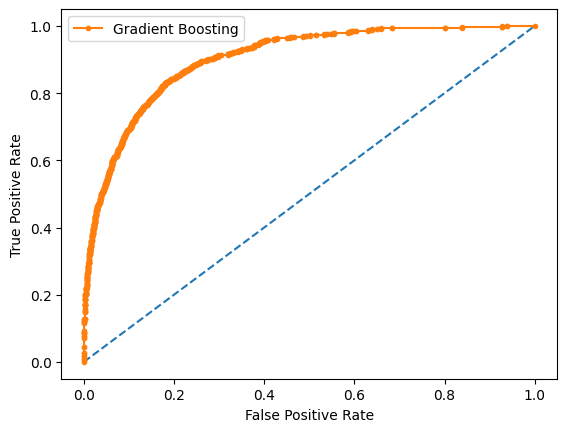

In [150]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot

fpr, tpr, thresholds = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--')
pyplot.plot(fpr, tpr, marker='.', label='Gradient Boosting')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

Seeing the baseline performance:

In [153]:
conf_matrix = confusion_matrix(y_test, predictions_baseline)
conf_matrix
FP = conf_matrix[0, 1]  # False positives
TN = conf_matrix[0, 0]  # True negatives
FN = conf_matrix[1, 0]  # False negatives
TP = conf_matrix[1, 1]  # True positives

# Compute FPR and FNR
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
TPR = TP / (TP + FN)
TNR = TN / (TN + FP)

FNR, FPR, TNR, TPR

(0.8520859671302149,
 0.007994272759813865,
 0.9920057272401861,
 0.14791403286978508)